# Imports

In [ ]:
!pip install pymc bambi arviz scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pymc as pm
import bambi as bm
import numpy as np
import arviz as az
from sklearn import datasets
from sklearn import linear_model
from sklearn import mixture
import scipy.stats as ss
import pandas as pd

# Data

In [ ]:
diabetes = datasets.load_diabetes()
iris = datasets.load_iris()

# Generalized Linear Models

## Linear, identity link function

[array([304.18307453]), 152.13348416289594]


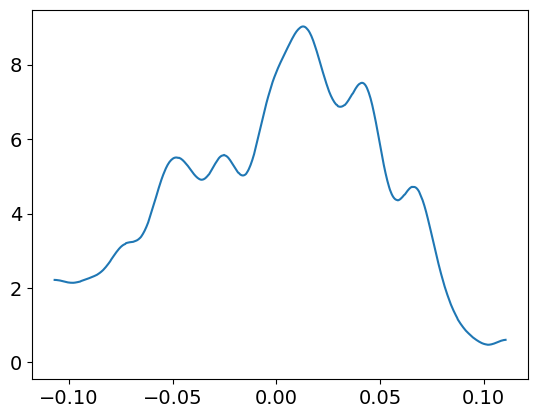

In [ ]:
x = diabetes["data"][:, 0]
y = diabetes["target"]

#for prior estimation
az.plot_dist(x)

#for model comparison
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(x.reshape(-1, 1), y)
print([lm.coef_, lm.intercept_])

In [ ]:
with pm.Model() as model:
    #priors
    beta0 = pm.Normal("beta0", 150, 100)
    beta1 = pm.Normal("beta1", 300, 100)
    ysigma = pm.HalfCauchy("ysigma", 10)

    #deterministic
    ymu = beta0 + beta1 * x

    #likelihood
    pm.Normal("likelihood", mu = ymu, sigma = ysigma, observed = y)

    #sampling
    samples = pm.sample()
    map_estimate = pm.find_MAP()

map_estimate

{'beta0': array(152.13096771),
 'beta1': array(300.00950108),
 'ysigma_log__': array(4.32369192),
 'ysigma': array(75.46673195)}

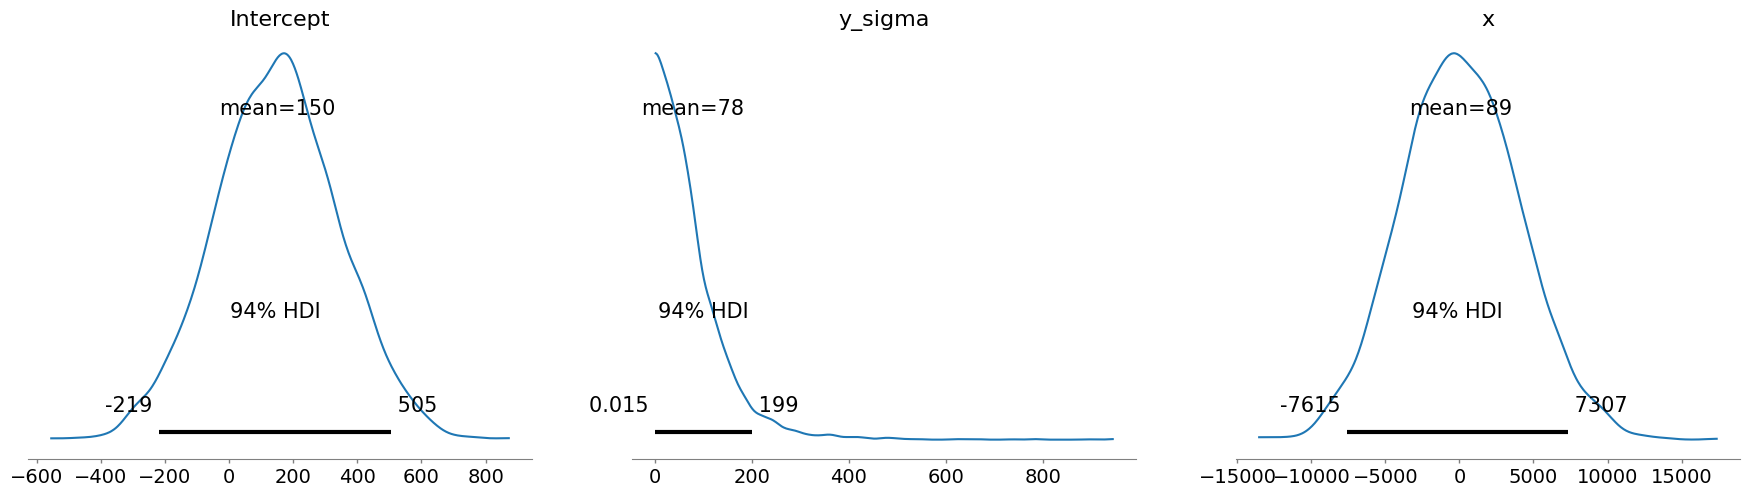

In [ ]:
df = pd.DataFrame({"x" : x, "y" : y})
model = bm.Model("y ~ x", df)
model.build()
model.plot_priors()
samples = model.fit()

## Other, specify link function

[array([[1.24051296]]), array([0.68694165])]


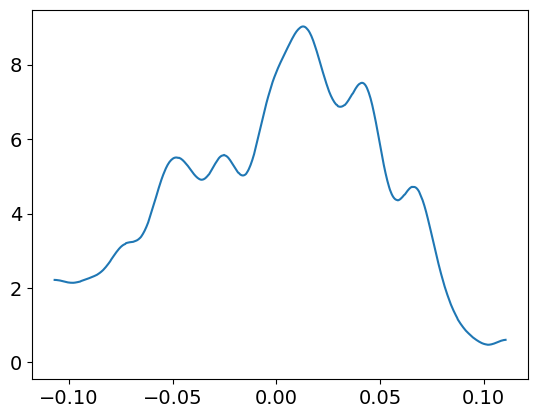

In [ ]:
x = diabetes["data"][:, 0]
y = (diabetes["target"] > 100).astype(int)

#for prior estimation
az.plot_dist(x)

#for model comparison
from sklearn import linear_model
lm = linear_model.LogisticRegression()
lm.fit(x.reshape(-1, 1), y)
print([lm.coef_, lm.intercept_])

In [ ]:
with pm.Model() as model:
    #priors
    beta0 = pm.Normal("beta0", 0, 10)
    beta1 = pm.Normal("beta1", 0, 10)

    #deterministic
    #use pm.deterministic to track values: pm.Deterministic("p", pm.invlogit(intercept + beta * x))
    ymu = beta0 + beta1 * x

    #linkage
    link = pm.invlogit(ymu)

    #likelihood
    pm.Bernoulli(name = "linklogit", p = link, observed = y)

    #sampling
    samples = pm.sample()
    map_estimate = pm.find_MAP()

map_estimate

{'beta0': array(0.70178646), 'beta1': array(6.55723019)}

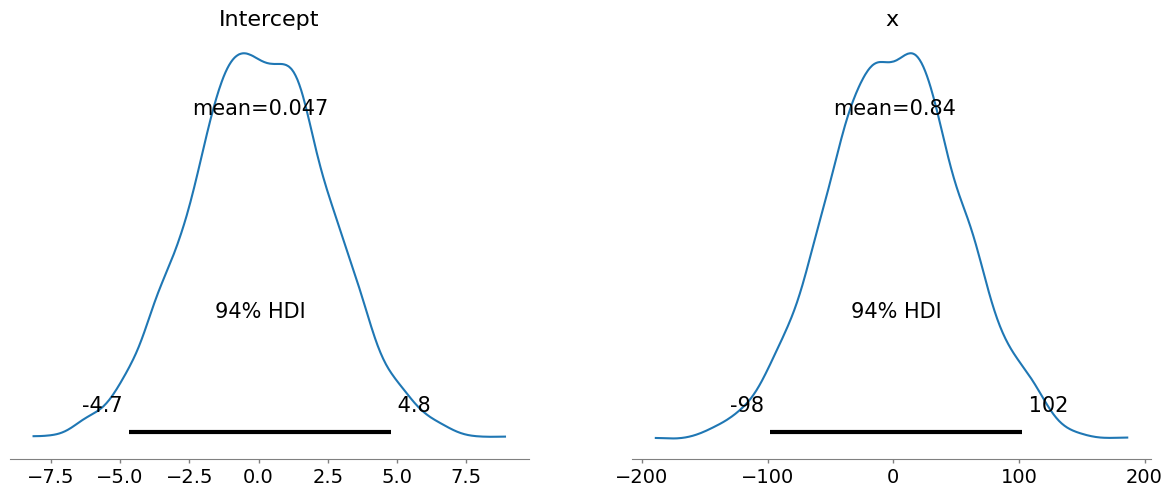

In [ ]:
df = pd.DataFrame({"x" : x, "y" : y})
model = bm.Model("y['1'] ~ x", df, family = "bernoulli")
model.build()
model.plot_priors()
samples = model.fit()

# AB Split Testing

TtestResult(statistic=-5.629165259719801, pvalue=1.7248563024547942e-07, df=98.0) ConfidenceInterval(low=-0.8818516246351231, high=-0.42214837536487365)


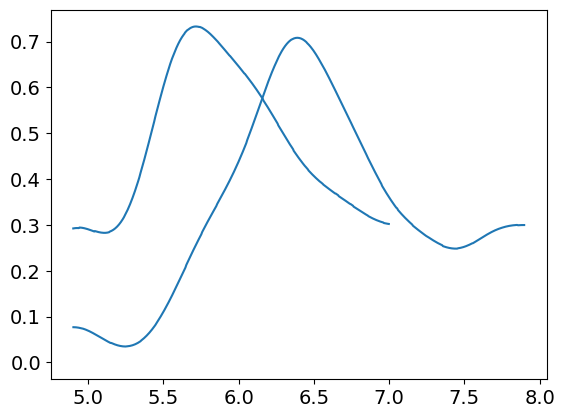

In [ ]:
x1 = iris["data"][:, 0][iris["target"] == 1]
x2 = iris["data"][:, 0][iris["target"] == 2]

#for prior estimation
az.plot_dist(x1)
az.plot_dist(x2)

#for model comparison
tt = ss.ttest_ind(x1, x2)
print(tt, tt.confidence_interval())

In [ ]:
with pm.Model() as model:
    #priors
    x1mu = pm.Normal("x1mu", mu = x1.mean(), sigma = x1.std())
    x2mu = pm.Normal("x2mu", mu = x2.mean(), sigma = x2.std())

    x1sigma = pm.Normal("x1sigma", mu = x1.std(), sigma = 10)
    x2sigma = pm.Normal("x2sigma", mu = x2.std(), sigma = 10)

    #deterministic
    meandiff = x1mu - x2mu
    effectsize = meandiff / np.sqrt((x1sigma ** 2 + x2sigma ** 2) / 2)
    pm.Deterministic("meandiff", var = meandiff)
    pm.Deterministic("effectsize", effectsize)

    #likelihood
    x1dist = pm.Normal("x1dist", mu = x1mu, sigma = x1sigma, observed = x1)
    x2dist = pm.Normal("x2dist", mu = x2mu, sigma = x2sigma, observed = x2)

    #sampling
    samples = pm.sample(10000, chains = 8, cores = 4)
    map_estimate = pm.find_MAP()

map_estimate

{'x1mu': array(5.936),
 'x2mu': array(6.588),
 'x1sigma': array(0.51098337),
 'x2sigma': array(0.62948868),
 'meandiff': array(-0.652),
 'effectsize': array(-1.13726312)}

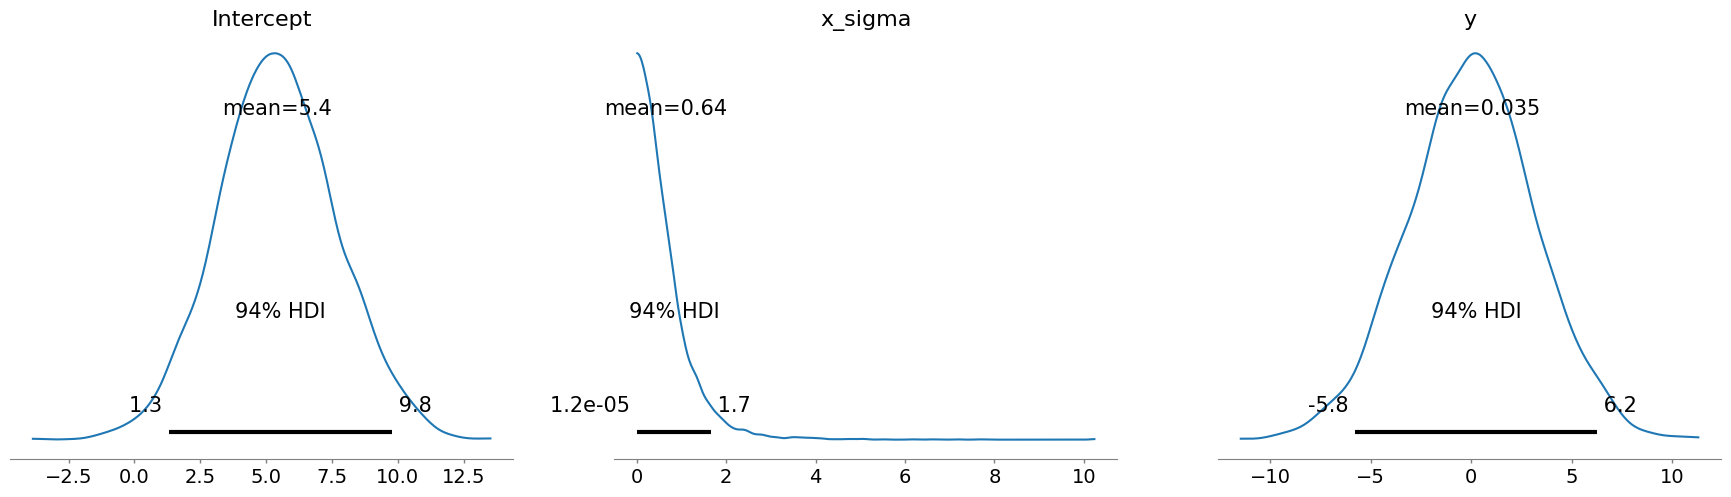

In [ ]:
df = pd.DataFrame({
    "x" : iris["data"][:, 0][iris["target"] != 2],
    "y" : iris["target"][iris["target"] != 2]
    })
model = bm.Model("x ~ y", df)
model.build()
model.plot_priors()
samples = model.fit()

# GMM Gaussian Mixture Model

[[4.90497803]
 [1.46175017]]
[[[0.67768389]]

 [[0.02946712]]]
[0.66688872 0.33311128]


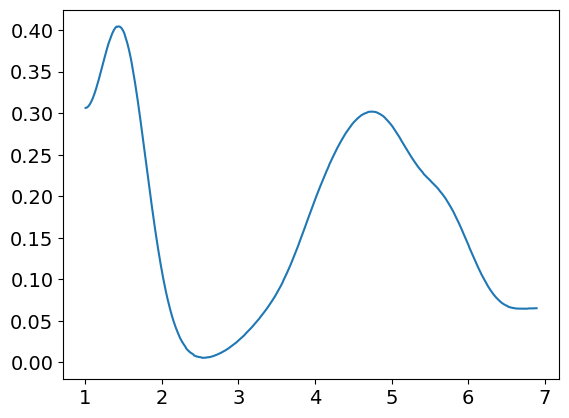

In [ ]:
x = iris["data"][:, 2]

#for prior estimation
az.plot_dist(x)

#for model comparison
k = 2
gmm = mixture.GaussianMixture(k)
gmm.fit(x.reshape(-1, 1))
print(gmm.means_)
print(gmm.covariances_)
print(gmm.weights_)

In [ ]:
with pm.Model(coords = {"cluster": range(k)}) as model:
    #priors
    mu = pm.Normal("mu", mu = 3, sigma = 2, transform = pm.distributions.transforms.univariate_ordered, initval = range(k), dims = "cluster")
    sigma = pm.HalfNormal("sigma", sigma = 1, dims = "cluster")
    weight = pm.Dirichlet("weight", np.ones(k), dims = "cluster")

    #likelihood
    pm.NormalMixture("x", w = weight, mu = mu, sigma = sigma, observed = x)

    #sampling
    map_estimate = pm.find_MAP()
    samples = pm.sample()

map_estimate

{'mu_ordered__': array([1.46198379, 1.23542064]),
 'sigma_log__': array([-1.762507  , -0.19794758]),
 'weight_simplex__': array([-0.34705866]),
 'mu': array([1.46198379, 4.90180892]),
 'sigma': array([0.17161409, 0.82041286]),
 'weight': array([0.33311778, 0.66688222])}

# ABC Approximate Bayesian Computation

<Axes: >

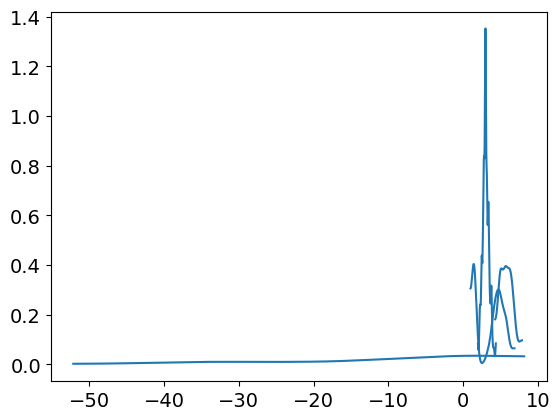

In [ ]:
def sim(rng, beta0, beta1, beta2, size = None):
    return beta0 + beta1 * rng.random(size = size) + beta1 * beta2 / 100 - beta2 * rng.random(size = size) * 10

x0 = iris["data"][:, 0]
x1 = iris["data"][:, 1]
x2 = iris["data"][:, 2]
x = [sim(np.random.default_rng(), i, j, k) for i, j, k in zip(x0, x1, x2)]

#for prior estimation
az.plot_dist(x0)
az.plot_dist(x1)
az.plot_dist(x2)
az.plot_dist(x)

In [ ]:
with pm.Model() as model:
    #priors
    beta0 = pm.Normal("beta0", mu = 6, sigma = 5)
    beta1 = pm.Normal("beta1", mu = 3, sigma = 1)
    beta2 = pm.Uniform("beta2", lower = 1, upper = 8)

    #simulation
    pm.Simulator("sim", sim, params = (beta0, beta1, beta2), sum_stat = "sort", epsilon = 1, observed = x)

    #sampling
    map_estimate = pm.find_MAP()
    samples = pm.sample()
    extend = samples.extend(pm.sample_posterior_predictive(samples))

map_estimate

{'beta0': array(7.94427191),
 'beta1': array(5.30403954),
 'beta2_interval__': array(0.06250779),
 'beta2': array(4.60935303)}

In [ ]:
df = pd.DataFrame({
    "x" : iris["data"][:, 0][iris["target"] != 2],
    "y" : iris["target"][iris["target"] != 2]
    })
model = bm.Model("x ~ y", df)
model.build()
model.plot_priors()
samples = model.fit()

# Viz

In [ ]:
pm.plot_posterior(samples, ref_val = 0)

In [ ]:
az.plot_trace(samples)

In [ ]:
az.summary(samples)